# Experiment: Varying N in top-N DDA fragmentation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
import sys
from collections import defaultdict
import seaborn as sns

In [3]:
sys.path.append('../codes')

In [4]:
from VMSfunctions.Chemicals import *
from VMSfunctions.Chromatograms import *
from VMSfunctions.MassSpec import *
from VMSfunctions.Controller import *
from VMSfunctions.Common import *
from VMSfunctions.DataGenerator import *
from VMSfunctions.Noise import *

### Useful functions

Performance is calculated by precision, recall and the mean square error of intensity when the fragmentation event occur to the maximum intensity of the chromatographic peak.

In [5]:
def find_chem(to_find, chem_list):
    for chem in chem_list:
        assert chem is not None
        assert to_find is not None
        if chem.max_intensity == to_find.max_intensity and \
            chem.rt == to_find.rt and \
            chem.chromatogram == to_find.chromatogram:
            return chem
    return None

In [6]:
def count_fragmented(chem, fragmented_chems):
    peaks = fragmented_chems[chem]
    ms_counts = defaultdict(int)
    for p in peaks:
        ms_counts[p.ms_level] += 1
    return ms_counts

In [15]:
def get_frag_events(controller, ms_level):
    filtered_frag_events = list(filter(lambda x: x.ms_level == ms_level, controller.mass_spec.fragmentation_events))
    chem_to_frag_events = defaultdict(list)
    for frag_event in filtered_frag_events:
        chem_to_frag_events[frag_event.chem].append(frag_event)
    return dict(chem_to_frag_events)

def count_frag_events(chem, chem_to_frag_events):
    frag_events = chem_to_frag_events[chem]
    count = 0
    for frag_event in frag_events:
        rt_match = chem.chromatogram._rt_match(frag_event.query_rt - chem.rt)
        if rt_match:
#             print('Good', frag_event)
#             print(chem.chromatogram.raw_rts)
            count += 1
#         else:
#             print('Bad', frag_event)
#             print(chem.chromatogram.raw_rts)            
    return count

def get_chem_frag_counts(chem_list, chem_to_frag_events):
    results = {}
    for i in range(len(chem_list)):
        chem = chem_list[i]
        found = find_chem(chem, chem_to_frag_events)
        try:
            count = count_frag_events(found, chem_to_frag_events)
        except KeyError:
            count = 0
        results[chem] = count
    return results

In [16]:
def compute_performance(controller, dataset):
    ms_level = 2
    chem_to_frag_events = get_frag_events(controller, ms_level)
    positives = list(filter(lambda x: x.type == 'data', dataset))
    negatives = list(filter(lambda x: x.type == 'noise', dataset))
    positives_count = get_chem_frag_counts(positives, chem_to_frag_events)
    negatives_count = get_chem_frag_counts(negatives, chem_to_frag_events)    

    # count the following:
    # true positive = is a real data and is fragmented
    # false positive = is not a real data but is fragmented
    # false negative = is a real data but is not fragmented

    tp = len([chem for chem in positives if positives_count[chem] > 0])
    fp = len([chem for chem in negatives if negatives_count[chem] > 0])
    fn = len([chem for chem in positives if positives_count[chem] == 0])

    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    f1 = ( 2 * prec * rec) / (prec + rec)
    prec, rec, f1
    
    print('tp=%d fp=%d fn=%d prec=%.3f rec=%.3f f1=%.3f' % (tp, fp, fn, prec, rec, f1))
    return tp, fp, fn, prec, rec, f1

In [17]:
def load_controller(results_dir, N, rt_tol):
    analysis_name = 'experiment_N_%d_rttol_%d' % (N, rt_tol)    
    pickle_in = '%s/%s.p' % (results_dir, analysis_name) 
    print('Loading %s' % analysis_name)                    
    try:
        controller = load_obj(pickle_in)
    except FileNotFoundError:
        controller = None
    return controller

### Load experiment results

In [18]:
results_dir = '../models/dda_results'

In [19]:
dataset = load_obj('%s/noisy_dataset.p' % results_dir)

### Compute performance

In [20]:
%matplotlib inline

In [21]:
# N = 10
# rt_tol = 15
# controller = load_controller(results_dir, N, rt_tol)
# compute_performance(controller, dataset)            

#### Fixed rt_tol = 15 and varying Ns

In [33]:
rt_tol = 15
Ns = list(range(2, 101, 2)) # top-N DDA fragmentation
Ns = list(range(5, 301, 5)) # top-N DDA fragmentation
results = []
for N in Ns:
    controller = load_controller(results_dir, N, rt_tol)
    if controller is not None:
         res = (N, rt_tol) + compute_performance(controller, dataset)            
    results.append(res)

Loading experiment_N_5_rttol_15
tp=594 fp=306 fn=9234 prec=0.660 rec=0.060 f1=0.111
Loading experiment_N_10_rttol_15
tp=985 fp=528 fn=8843 prec=0.651 rec=0.100 f1=0.174
Loading experiment_N_15_rttol_15
tp=1433 fp=720 fn=8395 prec=0.666 rec=0.146 f1=0.239
Loading experiment_N_20_rttol_15
tp=1804 fp=915 fn=8024 prec=0.663 rec=0.184 f1=0.288
Loading experiment_N_25_rttol_15
tp=2133 fp=1092 fn=7695 prec=0.661 rec=0.217 f1=0.327
Loading experiment_N_30_rttol_15
tp=2448 fp=1252 fn=7380 prec=0.662 rec=0.249 f1=0.362
Loading experiment_N_35_rttol_15
tp=2742 fp=1405 fn=7086 prec=0.661 rec=0.279 f1=0.392
Loading experiment_N_40_rttol_15
tp=2980 fp=1525 fn=6848 prec=0.661 rec=0.303 f1=0.416
Loading experiment_N_45_rttol_15
tp=3212 fp=1680 fn=6616 prec=0.657 rec=0.327 f1=0.436
Loading experiment_N_50_rttol_15
tp=3424 fp=1789 fn=6404 prec=0.657 rec=0.348 f1=0.455
Loading experiment_N_55_rttol_15
tp=3613 fp=1905 fn=6215 prec=0.655 rec=0.368 f1=0.471
Loading experiment_N_60_rttol_15
tp=3805 fp=2015 f

Text(0, 0.5, 'F1')

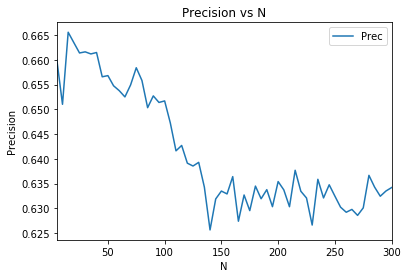

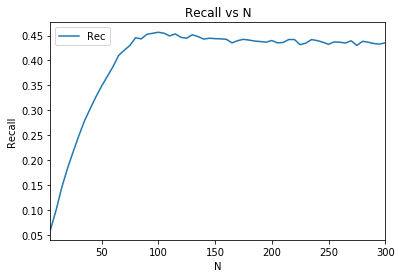

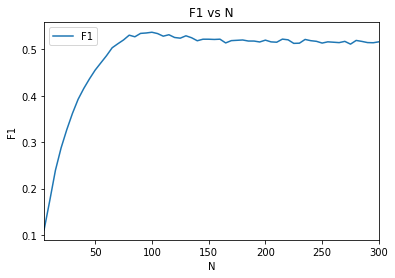

In [42]:
df = pd.DataFrame(results, columns=['N', 'rt_tol', 'TP', 'FP', 'FN', 'Prec', 'Rec', 'F1'])
df.plot.line(x='N', y=['Prec'])
plt.title('Precision vs N')
plt.ylabel('Precision')

df.plot.line(x='N', y=['Rec'])
plt.title('Recall vs N')
plt.ylabel('Recall')

df.plot.line(x='N', y=['F1'])
plt.title('F1 vs N')
plt.ylabel('F1')

In [35]:
df

,N,rt_tol,TP,FP,FN,Prec,Rec,F1
0,5,15,594,306,9234,0.660000,0.060440,0.110738
1,10,15,985,528,8843,0.651024,0.100224,0.173706
2,15,15,1433,720,8395,0.665583,0.145808,0.239212
3,20,15,1804,915,8024,0.663479,0.183557,0.287559
4,25,15,2133,1092,7695,0.661395,0.217033,0.326821
5,30,15,2448,1252,7380,0.661622,0.249084,0.361916
6,35,15,2742,1405,7086,0.661201,0.278999,0.392415
7,40,15,2980,1525,6848,0.661487,0.303215,0.415824
8,45,15,3212,1680,6616,0.656582,0.326821,0.436413
9,50,15,3424,1789,6404,0.656819,0.348392,0.455289


#### Fixed N = 10 and varying rt_tols

In [ ]:
Ns = [10]
rt_tols = list(range(5, 31, 5))
results = []
for N in Ns:
    for rt_tol in rt_tols:
        controller = load_controller(results_dir, N, rt_tol)
        if controller is not None:
             res = (N, rt_tol) + compute_performance(controller, dataset)            
        results.append(res)

In [ ]:
df = pd.DataFrame(results, columns=['N', 'rt_tol', 'TP', 'FP', 'FN', 'Prec', 'Rec', 'F1'])
df.plot.line(x='rt_tol', y=['Prec'])
df.plot.line(x='rt_tol', y=['Rec'])
df.plot.line(x='rt_tol', y=['F1'])

In [ ]:
df

### Compute performance for varying Ns and rt_tols

In [ ]:
Ns = list(range(2, 51, 2)) # top-N DDA fragmentation
rt_tols = list(range(5, 31, 5)) # the rt window around a selected precursor ion to prevent it from fragmented multiple times

In [ ]:
X, Y = np.meshgrid(Ns, rt_tols)
Z_precision = np.zeros_like(X).astype(float)
Z_recall = np.zeros_like(X).astype(float)
Z_f1 = np.zeros_like(X).astype(float)

In [ ]:
for j in range(X.shape[1]):
    for i in range(X.shape[0]):    
        N = X[i, j]
        rt_tol = Y[i, j]            
        analysis_name = 'experiment_N_%d_rttol_%d' % (N, rt_tol)    
        pickle_in = '%s/%s.p' % (results_dir, analysis_name) 

        print('Loading %s' % analysis_name)                    
        try:
            controller = load_obj(pickle_in)
        except FileNotFoundError:
            controller = None

        # compute performance
        if controller is not None:
            tp, fp, fn, prec, rec, f1 = compute_performance(controller, dataset)
            Z_precision[i, j] = prec
            Z_recall[i, j] = rec
            Z_f1[i, j] = f1

### Make plot

In [ ]:
plot_data = {
    'X': X,
    'Y': Y,
    'Z_precision': Z_precision,
    'Z_recall': Z_recall,
    'Z_f1': Z_f1
}

In [ ]:
save_obj(plot_data, results_dir + '/plot_data.p')

In [ ]:
def make_plot(X, Y, Z, xlabel, ylabel, zlabel, title):
    # Plot the surface.
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)

    # Customize the z axis.
    # ax.set_zlim(-1.01, 1.01)
    # ax.zaxis.set_major_locator(LinearLocator(10))
    # ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)    
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [ ]:
%matplotlib notebook

In [ ]:
make_plot(X, Y, Z_precision, 'N', 'Dynamic exclusion window (s)', 'Precision', 'Precision with varying Ns and dynamic exclusion windows')

In [ ]:
make_plot(X, Y, Z_recall, 'N', 'Dynamic exclusion window (s)', 'Recall', 'Recall with varying Ns and dynamic exclusion windows')

In [ ]:
make_plot(X, Y, Z_f1, 'N', 'Dynamic exclusion window (s)', 'F_1', 'F_1 score with varying Ns and dynamic exclusion windows')

In [ ]:
%matplotlib inline

In [ ]:
make_plot(X, Y, Z_precision, 'N', 'Dynamic exclusion window (s)', 'Precision', 'Precision with varying Ns and dynamic exclusion windows')

In [ ]:
make_plot(X, Y, Z_recall, 'N', 'Dynamic exclusion window (s)', 'Recall', 'Recall with varying Ns and dynamic exclusion windows')

In [ ]:
make_plot(X, Y, Z_f1, 'N', 'Dynamic exclusion window (s)', 'F_1', 'F_1 score with varying Ns and dynamic exclusion windows')